### Study .w5 coverage files to choose targets_human numbers

Run with enrollhd conda environment


In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
os.chdir("/pool01/projects/abante_lab/genomic_llms/")
project_id = "SRP074904"
caudate_w5_path = "human/rna/sra/SRP074904_caudate/summary/coverage.w5"
putamen_w5_path = "human/rna/sra/SRP074904_putamen/summary/coverage.w5"

# Output paths
caudate_w5_outpath = "human/rna/sra/SRP074904_caudate/summary/norm_coverage.w5"
putamen_w5_outpath = "human/rna/sra/SRP074904_putamen/summary/norm_coverage.w5"

In [4]:
#%% # Open the .w5 file
def open_w5_file(w5_path):
    """
    Open a .w5 file and return the dataset keys.
    """
    with h5py.File(w5_path, "r") as f:
        keys = list(f.keys())
        print(f"Found {len(keys)} datasets (chromosomes and control regions)")
        
        # Focus on chromosomes (filter out ERCC/SIRV/random etc.)
        chrom_keys = [k for k in keys if k.startswith("chr") and (k[3:].isdigit() or k[3:] in {"X", "Y"})]
        print("Using chromosomes:", chrom_keys[:5], "...")

        sample_data = []

        # Sample data from the first few chromosomes
        for chrom in chrom_keys[:5]:  # Adjust number for more precision
            dset = f[chrom][()]
            if dset.ndim == 1:
                sample = dset
                sample_data.append(sample)      
            else:
                continue  # skip if structure is unexpected

    # Concatenate sampled data
    data = np.concatenate(sample_data)

    return data, chrom_keys

In [5]:
caudate_data, caudate_keys = open_w5_file(caudate_w5_path)
putamen_data, putamen_keys = open_w5_file(putamen_w5_path)

Found 294 datasets (chromosomes and control regions)
Using chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13'] ...
Found 294 datasets (chromosomes and control regions)
Using chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13'] ...


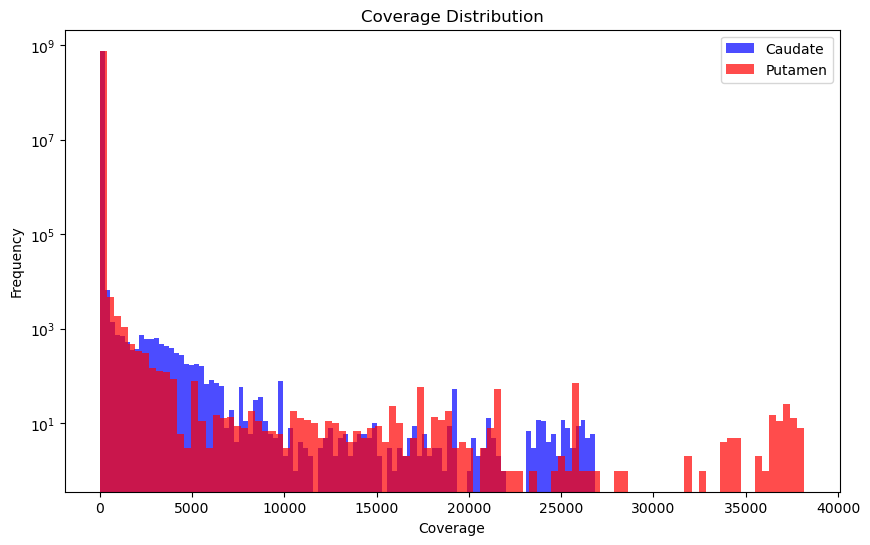

In [5]:
#%% # Plot the data
plt.figure(figsize=(10, 6))
plt.hist(caudate_data, bins=100, color="blue", alpha=0.7, label='Caudate')
plt.hist(putamen_data, bins=100, color="red", alpha=0.7, label='Putamen')
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Coverage Distribution")
plt.legend()
plt.show()

From Borzoi, talking about samples taken from recount3:

>These data were processed without consideration of strand information in recount3, which means the GTEx
training tracks are non-stranded while most other RNA-seq tracks are stranded. For these tracks, we scaled the aligned
fragment counts by the inverse of their average length in order to weight each fragment as a single event, in addition to
the exponentiation transform described above.

We can infer the average length of the fragments from the metadata files downloaded from recount3. First we need to know if the reads are single-end or paired-end:

In [6]:
df_qc = pd.read_csv("sra.recount_seq_qc.SRP074904.MD", sep="\t")
df_star = pd.read_csv("sra.recount_qc.SRP074904.MD", sep="\t")

# Merge metadata
df = df_qc.merge(df_star, on="rail_id")

# Estimate number of reads from base count and avg read length
df["estimated_reads"] = df["#bases"] / df["avg_len"]

# Compare with actual read count
df["reads_ratio"] = df["star.number_of_input_reads_both"] / df["estimated_reads"]

single_end = True
for sample in df["reads_ratio"]:
    if sample > 1.5:
        single_end = False
        break
print(f"Single-end reads: {single_end}")

Single-end reads: True


As they seem to be single-end reads (1 read = 1 fragment), we will use the `avg_len` column as the average fragment length.

In [18]:
df_qc

,rail_id,external_id,study,min_len,max_len,avg_len,#distinct_quality_values,#bases,%A,%C,%G,%T,%N,avgQ,errQ
0,469782,SRR3500562,SRP074904,100,100,100.0,38,1940114600,24.7,25.3,23.0,27.0,0.0,34.7,15.6
1,469790,SRR3500563,SRP074904,100,100,100.0,38,1965260800,25.2,24.2,22.9,27.7,0.0,35.0,16.0
2,469798,SRR3500564,SRP074904,100,100,100.0,38,1962628600,22.7,26.9,24.2,26.2,0.0,34.1,15.1
3,469805,SRR3500565,SRP074904,100,100,100.0,38,1860282200,25.9,23.4,21.9,28.8,0.0,35.2,16.1
4,469814,SRR3500566,SRP074904,100,100,100.0,38,1851536700,25.4,24.3,22.6,27.7,0.0,35.0,16.0
5,469823,SRR3500567,SRP074904,100,100,100.0,38,2074118500,24.6,24.1,22.5,28.9,0.0,34.9,15.8
6,469830,SRR3500568,SRP074904,100,100,100.0,38,2174214900,25.6,23.7,21.9,28.8,0.0,35.1,16.2
7,469838,SRR3500569,SRP074904,100,100,100.0,38,2337276900,20.5,27.1,24.9,27.5,0.0,33.5,14.4
8,469895,SRR3500570,SRP074904,99,99,99.0,38,2386230462,20.0,30.0,28.6,21.3,0.2,33.5,15.0
9,469901,SRR3500571,SRP074904,99,99,99.0,38,544009653,25.6,22.7,23.8,27.7,0.2,35.2,16.4


In [7]:
avg_len_caudate = 100
avg_len_putamen = 99

caudate_data = caudate_data / avg_len_caudate
putamen_data = putamen_data / avg_len_putamen

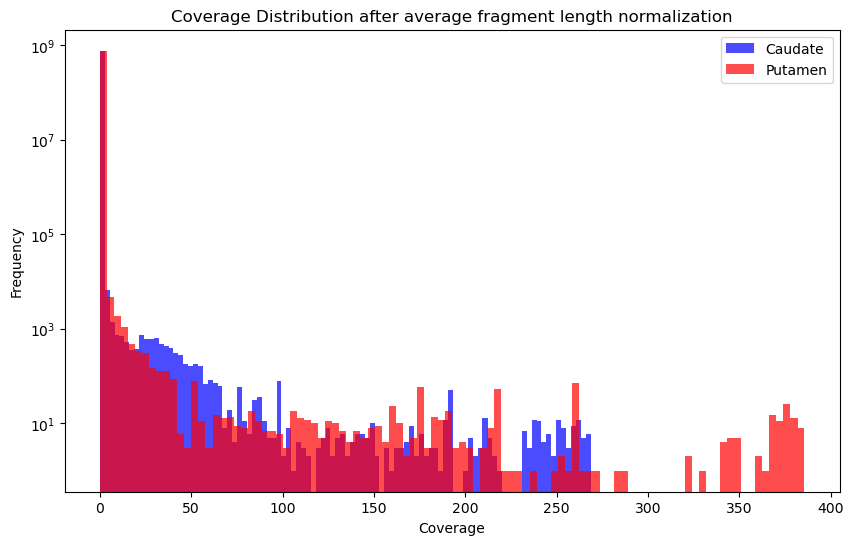

In [22]:
#%% # Plot the data
plt.figure(figsize=(10, 6))
plt.hist(caudate_data, bins=100, color="blue", alpha=0.7, label='Caudate')
plt.hist(putamen_data, bins=100, color="red", alpha=0.7, label='Putamen')
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Coverage Distribution after average fragment length normalization")
plt.legend()
plt.show()

Now we apply the second transformation used by Borzoi:

>Due to the relatively large dynamic range of RNA-seq, we normalized each coverage track by exponentiating its bin values by 3/4. If bin values were still larger than 384 after exponentiation, we applied an additional square root transform to the residual value. This set of transformations is referred to as ’Squashed scale’ in the main text.

In [8]:
clip_soft = 384

# Apply exponentiation of bin values by 3/4
normalized_caudate_data = np.power(caudate_data, 3/4)
normalized_putamen_data = np.power(putamen_data, 3/4)

# Apply square root transform if values exceed soft clip
# transformed_caudate_data = np.where(normalized_caudate_data > clip_soft, np.sqrt(normalized_caudate_data), normalized_caudate_data)
# transformed_putamen_data = np.where(normalized_putamen_data > clip_soft, np.sqrt(normalized_putamen_data), normalized_putamen_data)

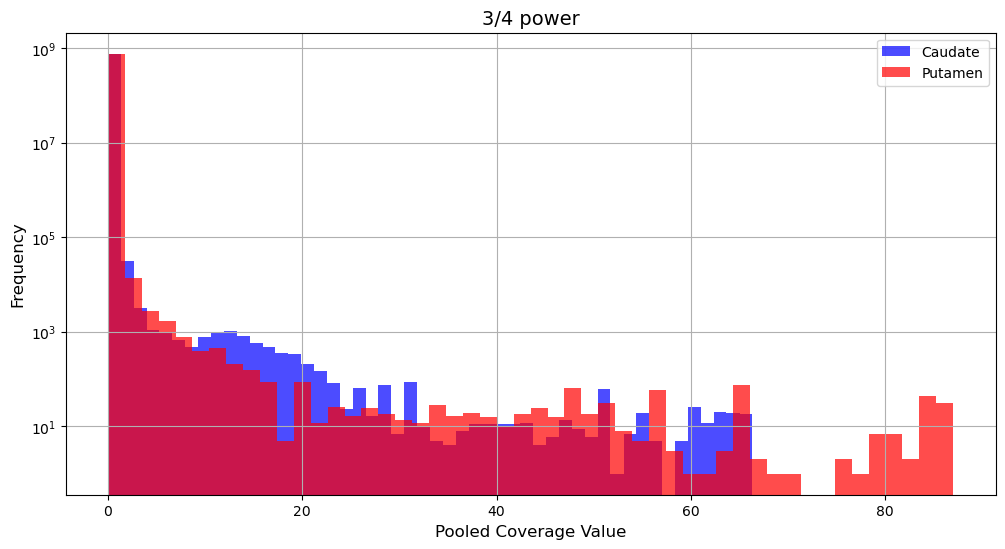

In [25]:
# Plot the histogram of the final pooled coverage
plt.figure(figsize=(12, 6))
plt.hist(normalized_caudate_data, bins=50, color="blue", alpha=0.7, label='Caudate')
plt.hist(normalized_putamen_data, bins=50, color="red", alpha=0.7, label='Putamen')
plt.title("3/4 power", fontsize=14)
plt.xlabel("Pooled Coverage Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

As there are no segments with more than 384 reads, we don't need to apply the sqrt transformation.

In [9]:
# Values for the target_human file
clip = 768 # not used
scale = 1.0 # not working in different magnitudes
strand_pair = 0  # same index if unstranded

In [29]:
# Generate the targets_human.txt entry
putamen_entry = {
    "index": 0,
    "identifier": project_id,
    "file": os.getcwd() + putamen_w5_path,
    "clip": clip,
    "clip_soft": clip_soft,
    "scale": scale,
    "sum_stat": "sum",
    "strand_pair": strand_pair,
    "description": f"RNA-seq: Putamen",
}
caudate_entry = {
    "index": 1,
    "identifier": project_id,
    "file": os.getcwd() + caudate_w5_path,
    "clip": clip,
    "clip_soft": clip_soft,
    "scale": scale,
    "sum_stat": "sum",
    "strand_pair": strand_pair,
    "description": f"RNA-seq: Caudate",
}
# Convert to tab-separated line (no header)
row1 = "\t".join(map(str, putamen_entry.values()))
row2 = "\t".join(map(str, caudate_entry.values()))

# Save the result
with open("human/rna/sra/targets_human.txt", "w") as out_f:
    # Write the header
    header = "\t".join(putamen_entry.keys())
    out_f.write(header + "\n")
    # Write the data
    out_f.write(row1 + "\n")
    out_f.write(row2 + "\n")

print("targets_human.txt created:\n")
print(row1)
print(row2)

targets_human.txt created:

0	SRP074904	/pool01/projects/abante_lab/genomic_llmshuman/rna/sra/SRP074904_putamen/summary/coverage.w5	768	384	1.0	sum	0	RNA-seq: Putamen
1	SRP074904	/pool01/projects/abante_lab/genomic_llmshuman/rna/sra/SRP074904_caudate/summary/coverage.w5	768	384	1.0	sum	0	RNA-seq: Caudate


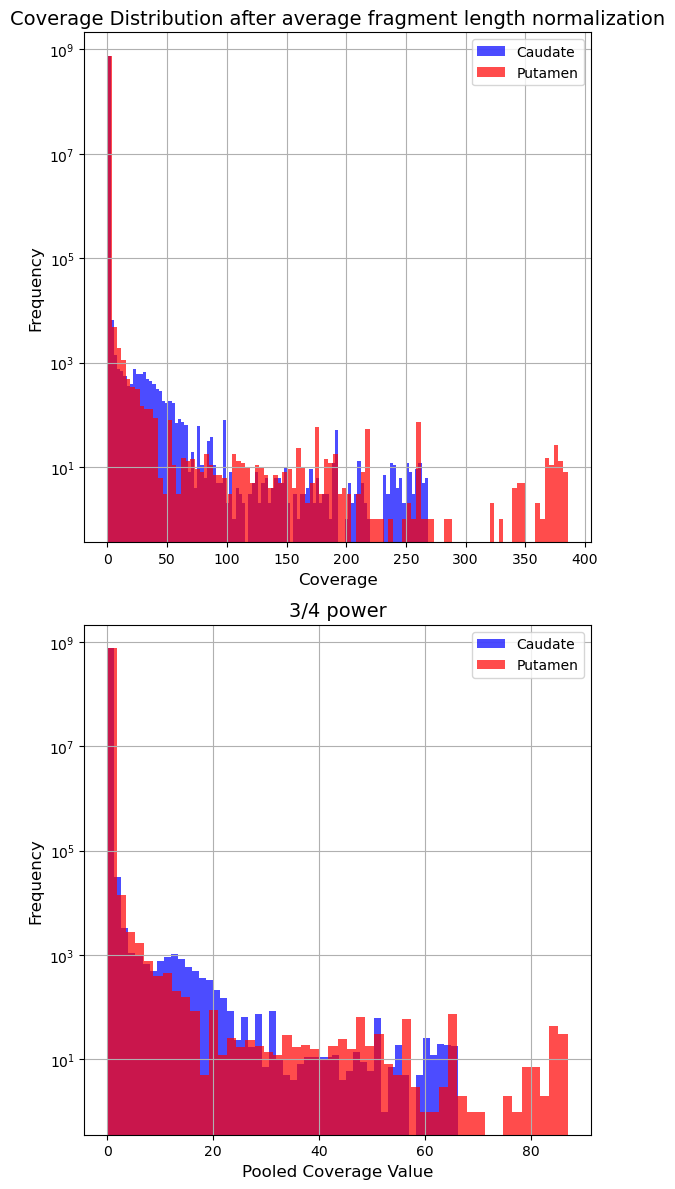

In [ ]:
# Create a figure with two subplots (one column, 3 rows)
fig, axs = plt.subplots(2, 1, figsize=(6, 10), sharex=False)

# Plot the histogram of the initial data
axs[0].hist(caudate_data, bins=100, color="blue", alpha=0.7, label='Caudate')
axs[0].hist(putamen_data, bins=100, color="red", alpha=0.7, label='Putamen')
axs[0].set_title("Coverage Distribution after average fragment length normalization", fontsize=14)
axs[0].set_xlabel("Coverage", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)
axs[0].set_yscale("log")
axs[0].legend()
axs[0].grid(True)

# Plot the histogram of the final pooled coverage
axs[1].hist(normalized_caudate_data, bins=50, color="blue", alpha=0.7, label='Caudate')
axs[1].hist(normalized_putamen_data, bins=50, color="red", alpha=0.7, label='Putamen')
axs[1].set_title("3/4 power", fontsize=14)
axs[1].set_xlabel("Pooled Coverage Value", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
axs[1].set_yscale("log")
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [11]:
# Write the normalized data to a file
# Write normalized data into .w5 files
with h5py.File(caudate_w5_outpath, "w") as f:
    f.create_dataset("normalized_data", data=normalized_caudate_data)
    f.attrs["description"] = "Normalized caudate data"
    f.attrs["project_id"] = project_id

with h5py.File(putamen_w5_outpath, "w") as f:
    f.create_dataset("normalized_data", data=normalized_putamen_data)
    f.attrs["description"] = "Normalized putamen data"
    f.attrs["project_id"] = project_id

print(f"Normalized data written to {caudate_w5_outpath} and {putamen_w5_outpath}")

Normalized data written to human/rna/sra/SRP074904_caudate/summary/norm_coverage.w5 and human/rna/sra/SRP074904_putamen/summary/norm_coverage.w5


In [12]:
# Generate the norm_targets_human.txt entry
putamen_entry = {
    "index": 0,
    "identifier": project_id,
    "file": os.getcwd() + putamen_w5_outpath,
    "clip": clip,
    "clip_soft": clip_soft,
    "scale": scale,
    "sum_stat": "sum",
    "strand_pair": strand_pair,
    "description": f"RNA-seq: Putamen",
}
caudate_entry = {
    "index": 1,
    "identifier": project_id,
    "file": os.getcwd() + caudate_w5_outpath,
    "clip": clip,
    "clip_soft": clip_soft,
    "scale": scale,
    "sum_stat": "sum",
    "strand_pair": strand_pair,
    "description": f"RNA-seq: Caudate",
}
# Convert to tab-separated line (no header)
row1 = "\t".join(map(str, putamen_entry.values()))
row2 = "\t".join(map(str, caudate_entry.values()))

# Save the result
with open("human/rna/sra/norm_targets_human.txt", "w") as out_f:
    # Write the header
    header = "\t".join(putamen_entry.keys())
    out_f.write(header + "\n")
    # Write the data
    out_f.write(row1 + "\n")
    out_f.write(row2 + "\n")

print("norm_targets_human.txt created:\n")
print(row1)
print(row2)

norm_targets_human.txt created:

0	SRP074904	/pool01/projects/abante_lab/genomic_llmshuman/rna/sra/SRP074904_putamen/summary/norm_coverage.w5	768	384	1.0	sum	0	RNA-seq: Putamen
1	SRP074904	/pool01/projects/abante_lab/genomic_llmshuman/rna/sra/SRP074904_caudate/summary/norm_coverage.w5	768	384	1.0	sum	0	RNA-seq: Caudate
